In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn

from scipy.ndimage.interpolation import zoom
from sklearn.utils import shuffle
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import os
import time
import h5py

# keras
from keras.models import Sequential
from keras.layers import Input, Conv3D, Flatten, Dense, MaxPooling3D, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import Sequence

from config import *
from utils import specificity
from utils import sensitivity

Using TensorFlow backend.


In [3]:
# Start timing
start_time = time.time()

In [4]:
# Tensorflow settings
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session, get_session

config = tf.ConfigProto()
config.gpu_options.visible_device_list = "5"
sess = tf.Session(config=config)
set_session(sess)

In [5]:
dtype = np.float32
result_dir = "/analysis/share/Ritter/models/fabi/ADNI/pretraining_paper/NO_MCI/"

In [6]:
!mkdir -p $result_dir

In [7]:
# load hdf5 files and extract columns
#train_h5 = h5py.File("/analysis/share/ADNI/HDF5_files/NO_MCI_train_2yr_and_unique_screening-921_subjects-96_114_96_shape-masked.h5", 'r')
train_h5 = h5py.File("/analysis/fabiane/data/ADNI_hdf5/image_array_AD_CN_2Yr15T_plus_UniqueScreening_quickprep_(96, 114, 96)_old.h5")
holdout_h5 = h5py.File("/analysis/share/ADNI/HDF5_files/NO_MCI_test_2yr_and_unique_screening-150_subjects-96_114_96_shape-masked.h5", 'r')

#X_train, y_train, files_train = train_h5['X'], train_h5['y'], train_h5["files"]
X_train, y_train, files_train = train_h5['X'], train_h5['y'], train_h5["used_imgs"]
X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']

In [8]:
# convert data to numpy arrays
#X_train = np.expand_dims(np.array(X_train, dtype=dtype), 4)
X_train = np.array(X_train, dtype=dtype)
y_train = np.array(y_train)

X_holdout = np.expand_dims(np.array(X_holdout, dtype=dtype), 4)
y_holdout = np.array(y_holdout)

In [9]:
print("Total datset length: {}".format(len(y_train)))
print("Number of healthy controls: {}".format(len(np.array(y_train)[np.array(y_train)==0.])))
print("Number of AD patients: {}".format(len(np.array(y_train)[np.array(y_train)==1.])))

Total datset length: 747
Number of healthy controls: 368
Number of AD patients: 379


In [10]:
### Split Test and Remain
from collections import Counter
model_dir =  "/analysis/fabiane/other_code/felix/convnet-mci-ad-prediction/"

# load remain and test indices
test_fn = os.path.join(model_dir, 'test_indices_CN67_AD78_20181119-151805_image_array_AD_CN_2Yr15T_plus_UniqueScreening_quickprep_(96, 114, 96).npy')
remain_fn = os.path.join(model_dir, 'remain_indices_CN301_AD301_20181119-151805_image_array_AD_CN_2Yr15T_plus_UniqueScreening_quickprep_(96, 114, 96).npy')

remain_indices = np.load(remain_fn); print(Counter(y_train[remain_indices,0])); print(len(remain_indices))
test_indices  = np.load(test_fn);  print(Counter(y_train[test_indices,0]));  print(len(test_indices)) 

# test of sets disjunct
#len(set([str(filename)[2:12] for filename in files_train[remain_indices]]).intersection(set([str(filename)[2:12] for filename in files_train[test_indices]])))

# split images
X_remain = X_train[remain_indices]
print(X_remain.shape)
y_remain = y_train[remain_indices,0]
print(y_remain.shape)
X_val  = X_train[test_indices]
y_val  = y_train[test_indices,0] 

Counter({1: 301, 0: 301})
602
Counter({1: 78, 0: 67})
145
(602, 96, 114, 96, 1)
(602,)


In [11]:
class ADNIDataset(Sequence):
    def __init__(self, X, y, transform=None, batch_size=4, z_factor=None, shuffle=True, mask=None):
        self.X = X
        self.y = y
        self.transform = transform
        self.batch_size = batch_size
        self.z_factor = z_factor
        self.shuffle = shuffle
        self.mask = mask
        
    def __len__(self):
        return int(np.ceil(len(self.y)/self.batch_size))
    
    def __getitem__(self, idx):
        # add BET
        image = np.expand_dims(self.X[idx * self.batch_size:(idx + 1) * self.batch_size],5)
        label = np.array(self.y[idx * self.batch_size:(idx + 1) * self.batch_size], dtype=np.int8)
        
        if self.mask is not None:
            for i in range(image.shape[0]):
                image[i] *= self.mask
        
        for transformation in self.transform:
            image = transformation(image)
        
        return image, label
    
    def on_epoch_end(self):
        if self.shuffle:
            self.X, self.y = shuffle(self.X, self.y)

In [12]:
# images are already masked
mask = None

# Model

In [13]:
def SixtyFourNet(input_shape, drop_rate=0., weight_dcay=0.):
    model = Sequential()
    model.add(Conv3D(64, kernel_size=3, 
                     input_shape=(input_shape[1], input_shape[2], input_shape[3], 1), 
                     activation='elu', padding='valid', name='Conv_1'))
    model.add(MaxPooling3D(pool_size=3, name='Pool_1'))
    model.add(Dropout(drop_rate))
    model.add(Conv3D(64, kernel_size=3, padding='valid', activation='elu', name='Conv_2'))

    model.add(MaxPooling3D(pool_size=3, name='Pool_2'))
    model.add(Dropout(drop_rate))

    model.add(Conv3D(64, kernel_size=3, padding='valid', activation='elu', name='Conv_3',
                     kernel_regularizer=l2(weight_dcay)))
    model.add(Conv3D(64, kernel_size=3, padding='valid', activation='elu', name='Conv_4',
                     kernel_regularizer=l2(weight_dcay)))
    model.add(MaxPooling3D(pool_size=3, name='Pool_4'))
    model.add(Dropout(drop_rate))

    model.add(Flatten())
    model.add(Dense(units=1, activation='sigmoid'))
    return model

# Normalization

files_train = np.array(files_train)

names_train = [item[53:53+10].decode('utf-8') for item in files_train]

### Split data

GSS = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=22)
indices = list(GSS.split(names_train, groups=names_train))[0]
train_idx, val_idx = indices[0], indices[1]

# shuffle indices test
np.random.shuffle(train_idx)
np.random.shuffle(val_idx)

# Subtract validation set
X_val = X_train[val_idx]
X_train = X_train[train_idx]
y_val = y_train[val_idx]
y_train = y_train[train_idx]

### Normalize min-max

In [14]:
for i in range(len(X_train)):
    X_train[i] -= np.min(X_train[i])
    X_train[i] /= np.max(X_train[i])
    
for i in range(len(X_val)):
    X_val[i] -= np.min(X_val[i])
    X_val[i] /= np.max(X_val[i])
    
for i in range(len(X_holdout)):
    X_holdout[i] -= np.min(X_holdout[i])
    X_holdout[i] /= np.max(X_holdout[i])

### Normalize by voxel

In [15]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean) / (std)
X_val = (X_val - mean) / (std)

In [16]:
X_train.shape

(747, 96, 114, 96, 1)

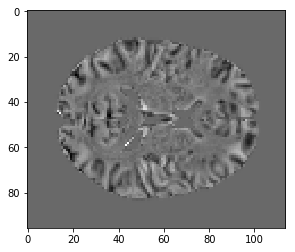

In [17]:
plt.imshow(X_train[4][:,:,46,0], cmap='gray')
plt.show()

(array([  1.,   4.,   5.,  20.,  32.,  67.,  90., 221., 253.,  54.]),
 array([-4.8973165 , -4.23189   , -3.5664642 , -2.901038  , -2.2356117 ,
        -1.5701857 , -0.9047594 , -0.23933326,  0.42609292,  1.0915191 ,
         1.7569453 ], dtype=float32),
 <a list of 10 Patch objects>)

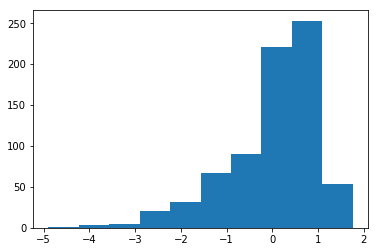

In [18]:
plt.hist(X_train[:,40,71,40,0].flatten())

In [19]:
X_train[4][:,:,46, 0]

array([[0.13926934, 0.13926934, 0.13926934, ..., 0.13926934, 0.13926934,
        0.13926934],
       [0.13926934, 0.13926934, 0.13926934, ..., 0.13926934, 0.13926934,
        0.13926934],
       [0.13926934, 0.13926934, 0.13926934, ..., 0.13926934, 0.13926934,
        0.13926934],
       ...,
       [0.13926934, 0.13926934, 0.13926934, ..., 0.13926934, 0.13926934,
        0.13926934],
       [0.13926934, 0.13926934, 0.13926934, ..., 0.13926934, 0.13926934,
        0.13926934],
       [0.13926934, 0.13926934, 0.13926934, ..., 0.13926934, 0.13926934,
        0.13926934]], dtype=float32)

# Training

Train on 747 samples, validate on 145 samples
Epoch 1/45
747/747 [==============================] - 38s 50ms/step - loss: 2.0375 - acc: 0.5435 - val_loss: 1.8993 - val_acc: 0.4621
Epoch 2/45
747/747 [==============================] - 34s 45ms/step - loss: 1.6387 - acc: 0.5837 - val_loss: 1.4138 - val_acc: 0.6414
Epoch 3/45
747/747 [==============================] - 34s 45ms/step - loss: 1.2954 - acc: 0.6774 - val_loss: 1.5513 - val_acc: 0.5586
Epoch 4/45
747/747 [==============================] - 34s 45ms/step - loss: 1.0775 - acc: 0.7269 - val_loss: 0.9323 - val_acc: 0.7103
Epoch 5/45
747/747 [==============================] - 34s 46ms/step - loss: 0.9788 - acc: 0.7269 - val_loss: 0.8638 - val_acc: 0.7310
Epoch 6/45
747/747 [==============================] - 34s 45ms/step - loss: 0.7814 - acc: 0.7831 - val_loss: 0.7227 - val_acc: 0.7517
Epoch 7/45
747/747 [==============================] - 34s 45ms/step - loss: 0.7565 - acc: 0.7845 - val_loss: 0.5899 - val_acc: 0.8414
Epoch 8/45
747/7

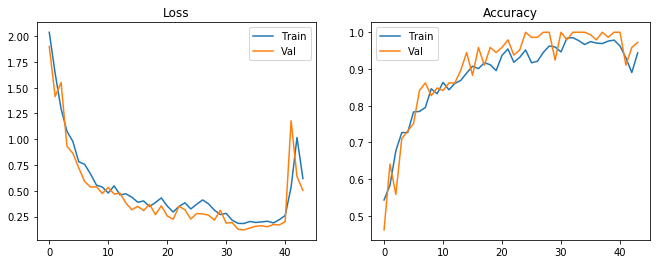

Final epoch results:
Balanced Accuracy: 97.01 %
Sensitivity: 100.00 %
Specificity: 94.03 %
Train on 747 samples, validate on 145 samples
Epoch 1/45
747/747 [==============================] - 35s 47ms/step - loss: 2.0103 - acc: 0.5221 - val_loss: 1.7659 - val_acc: 0.5379
Epoch 2/45
747/747 [==============================] - 34s 46ms/step - loss: 1.6377 - acc: 0.5890 - val_loss: 1.3756 - val_acc: 0.6483
Epoch 3/45
747/747 [==============================] - 34s 45ms/step - loss: 1.2366 - acc: 0.6854 - val_loss: 1.0099 - val_acc: 0.7379
Epoch 4/45
747/747 [==============================] - 34s 45ms/step - loss: 1.0358 - acc: 0.7216 - val_loss: 0.9393 - val_acc: 0.7655
Epoch 5/45
747/747 [==============================] - 34s 46ms/step - loss: 0.8879 - acc: 0.7617 - val_loss: 0.6767 - val_acc: 0.8690
Epoch 6/45
747/747 [==============================] - 34s 46ms/step - loss: 0.7566 - acc: 0.8166 - val_loss: 0.6238 - val_acc: 0.8207
Epoch 7/45
747/747 [==============================] - 34s 4

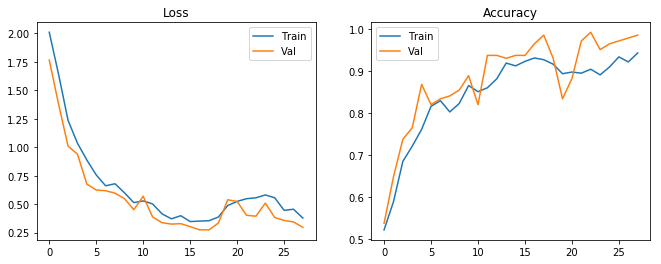

Final epoch results:
Balanced Accuracy: 98.51 %
Sensitivity: 100.00 %
Specificity: 97.01 %
Train on 747 samples, validate on 145 samples
Epoch 1/45
747/747 [==============================] - 36s 48ms/step - loss: 2.0357 - acc: 0.5127 - val_loss: 2.0120 - val_acc: 0.4621
Epoch 2/45
747/747 [==============================] - 35s 47ms/step - loss: 1.6011 - acc: 0.5930 - val_loss: 1.2915 - val_acc: 0.7172
Epoch 3/45
747/747 [==============================] - 35s 47ms/step - loss: 1.2338 - acc: 0.6867 - val_loss: 0.9972 - val_acc: 0.7724
Epoch 4/45
747/747 [==============================] - 35s 47ms/step - loss: 0.9955 - acc: 0.7189 - val_loss: 0.9415 - val_acc: 0.7448
Epoch 5/45
747/747 [==============================] - 35s 47ms/step - loss: 0.9433 - acc: 0.7403 - val_loss: 0.7359 - val_acc: 0.7724
Epoch 6/45
747/747 [==============================] - 35s 47ms/step - loss: 0.7447 - acc: 0.7938 - val_loss: 0.6744 - val_acc: 0.8000
Epoch 7/45
747/747 [==============================] - 35s 4

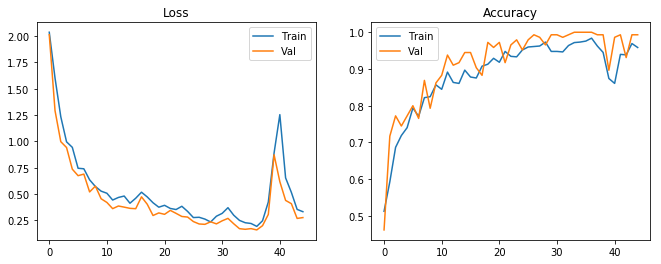

Final epoch results:
Balanced Accuracy: 99.25 %
Sensitivity: 100.00 %
Specificity: 98.51 %
Train on 747 samples, validate on 145 samples
Epoch 1/45
747/747 [==============================] - 36s 49ms/step - loss: 1.9569 - acc: 0.5248 - val_loss: 1.7122 - val_acc: 0.5517
Epoch 2/45
747/747 [==============================] - 35s 47ms/step - loss: 1.5708 - acc: 0.5301 - val_loss: 1.2970 - val_acc: 0.6069
Epoch 3/45
747/747 [==============================] - 35s 47ms/step - loss: 1.2545 - acc: 0.5957 - val_loss: 1.0695 - val_acc: 0.6621
Epoch 4/45
747/747 [==============================] - 35s 47ms/step - loss: 1.0215 - acc: 0.7108 - val_loss: 0.9100 - val_acc: 0.7724
Epoch 5/45
747/747 [==============================] - 35s 47ms/step - loss: 0.8814 - acc: 0.7296 - val_loss: 0.7484 - val_acc: 0.7793
Epoch 6/45
747/747 [==============================] - 35s 47ms/step - loss: 0.8249 - acc: 0.7403 - val_loss: 0.6617 - val_acc: 0.8276
Epoch 7/45
747/747 [==============================] - 35s 4

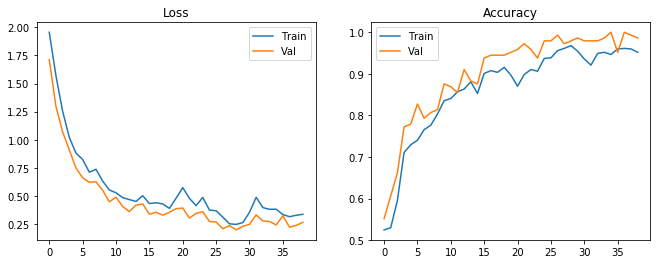

Final epoch results:
Balanced Accuracy: 98.72 %
Sensitivity: 97.44 %
Specificity: 100.00 %
Train on 747 samples, validate on 145 samples
Epoch 1/45
747/747 [==============================] - 36s 48ms/step - loss: 2.0841 - acc: 0.4926 - val_loss: 1.7782 - val_acc: 0.4621
Epoch 2/45
747/747 [==============================] - 35s 47ms/step - loss: 1.6437 - acc: 0.5716 - val_loss: 1.3877 - val_acc: 0.6276
Epoch 3/45
747/747 [==============================] - 35s 47ms/step - loss: 1.3789 - acc: 0.6171 - val_loss: 1.1598 - val_acc: 0.7103
Epoch 4/45
747/747 [==============================] - 35s 47ms/step - loss: 1.2254 - acc: 0.6372 - val_loss: 1.1338 - val_acc: 0.5586
Epoch 5/45
747/747 [==============================] - 35s 47ms/step - loss: 1.0269 - acc: 0.6841 - val_loss: 0.8218 - val_acc: 0.7241
Epoch 6/45
747/747 [==============================] - 35s 47ms/step - loss: 0.8700 - acc: 0.7216 - val_loss: 0.7343 - val_acc: 0.7862
Epoch 7/45
747/747 [==============================] - 35s 4

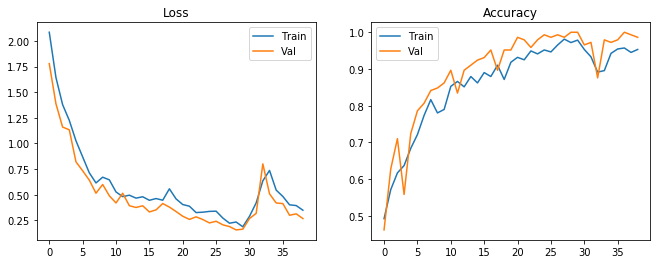

Final epoch results:
Balanced Accuracy: 98.72 %
Sensitivity: 97.44 %
Specificity: 100.00 %
Train on 747 samples, validate on 145 samples
Epoch 1/45
747/747 [==============================] - 36s 48ms/step - loss: 2.0487 - acc: 0.5181 - val_loss: 1.6992 - val_acc: 0.6069
Epoch 2/45
747/747 [==============================] - 35s 47ms/step - loss: 1.7326 - acc: 0.5569 - val_loss: 1.4851 - val_acc: 0.5724
Epoch 3/45
747/747 [==============================] - 35s 47ms/step - loss: 1.3463 - acc: 0.6627 - val_loss: 1.2228 - val_acc: 0.6483
Epoch 4/45
747/747 [==============================] - 35s 47ms/step - loss: 1.0751 - acc: 0.7430 - val_loss: 0.8706 - val_acc: 0.7931
Epoch 5/45
747/747 [==============================] - 35s 47ms/step - loss: 0.9149 - acc: 0.7711 - val_loss: 1.0219 - val_acc: 0.7724
Epoch 6/45
747/747 [==============================] - 35s 47ms/step - loss: 0.8608 - acc: 0.7764 - val_loss: 0.6448 - val_acc: 0.8690
Epoch 7/45
747/747 [==============================] - 35s 4

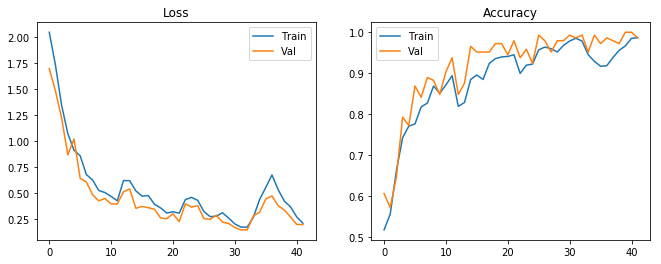

Final epoch results:
Balanced Accuracy: 98.72 %
Sensitivity: 97.44 %
Specificity: 100.00 %
Train on 747 samples, validate on 145 samples
Epoch 1/45
747/747 [==============================] - 36s 49ms/step - loss: 1.9507 - acc: 0.5435 - val_loss: 1.6166 - val_acc: 0.7034
Epoch 2/45
747/747 [==============================] - 35s 46ms/step - loss: 1.5433 - acc: 0.5890 - val_loss: 1.3039 - val_acc: 0.6552
Epoch 3/45
747/747 [==============================] - 35s 47ms/step - loss: 1.2308 - acc: 0.7001 - val_loss: 1.0526 - val_acc: 0.7724
Epoch 4/45
747/747 [==============================] - 35s 47ms/step - loss: 1.0474 - acc: 0.7028 - val_loss: 0.9006 - val_acc: 0.7517
Epoch 5/45
747/747 [==============================] - 35s 47ms/step - loss: 0.9321 - acc: 0.7323 - val_loss: 0.8664 - val_acc: 0.6828
Epoch 6/45
747/747 [==============================] - 35s 47ms/step - loss: 0.7592 - acc: 0.7845 - val_loss: 0.6462 - val_acc: 0.8345
Epoch 7/45
747/747 [==============================] - 35s 4

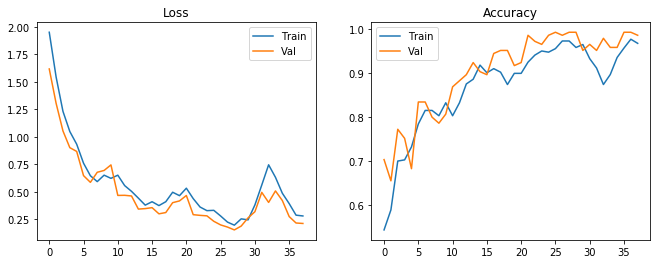

Final epoch results:
Balanced Accuracy: 98.61 %
Sensitivity: 98.72 %
Specificity: 98.51 %
Train on 747 samples, validate on 145 samples
Epoch 1/45
747/747 [==============================] - 36s 49ms/step - loss: 2.0166 - acc: 0.5127 - val_loss: 1.6574 - val_acc: 0.5931
Epoch 2/45
747/747 [==============================] - 35s 46ms/step - loss: 1.5296 - acc: 0.5971 - val_loss: 1.2762 - val_acc: 0.7103
Epoch 3/45
747/747 [==============================] - 35s 46ms/step - loss: 1.2199 - acc: 0.7108 - val_loss: 1.0227 - val_acc: 0.7310
Epoch 4/45
747/747 [==============================] - 35s 46ms/step - loss: 0.9957 - acc: 0.7470 - val_loss: 0.8779 - val_acc: 0.7586
Epoch 5/45
747/747 [==============================] - 35s 46ms/step - loss: 0.8979 - acc: 0.7684 - val_loss: 0.8980 - val_acc: 0.7517
Epoch 6/45
747/747 [==============================] - 35s 47ms/step - loss: 0.7938 - acc: 0.7831 - val_loss: 0.7322 - val_acc: 0.7517
Epoch 7/45
747/747 [==============================] - 35s 47

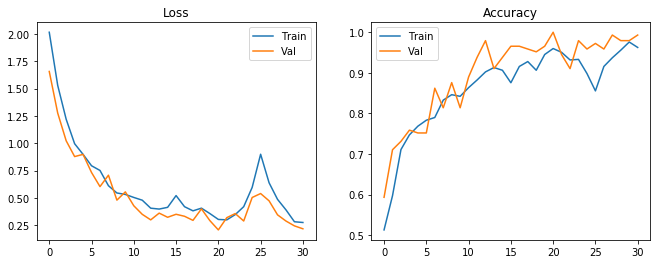

Final epoch results:
Balanced Accuracy: 99.36 %
Sensitivity: 98.72 %
Specificity: 100.00 %
Train on 747 samples, validate on 145 samples
Epoch 1/45
747/747 [==============================] - 36s 48ms/step - loss: 2.0708 - acc: 0.5395 - val_loss: 1.7044 - val_acc: 0.6621
Epoch 2/45
747/747 [==============================] - 35s 46ms/step - loss: 1.6823 - acc: 0.5341 - val_loss: 1.5110 - val_acc: 0.5379
Epoch 3/45
747/747 [==============================] - 35s 46ms/step - loss: 1.4138 - acc: 0.5716 - val_loss: 1.2041 - val_acc: 0.6207
Epoch 4/45
747/747 [==============================] - 34s 46ms/step - loss: 1.1895 - acc: 0.6345 - val_loss: 1.1547 - val_acc: 0.6345
Epoch 5/45
747/747 [==============================] - 35s 46ms/step - loss: 1.0300 - acc: 0.6720 - val_loss: 0.8694 - val_acc: 0.6966
Epoch 6/45
747/747 [==============================] - 35s 47ms/step - loss: 0.7827 - acc: 0.7831 - val_loss: 0.6591 - val_acc: 0.8069
Epoch 7/45
747/747 [==============================] - 34s 4

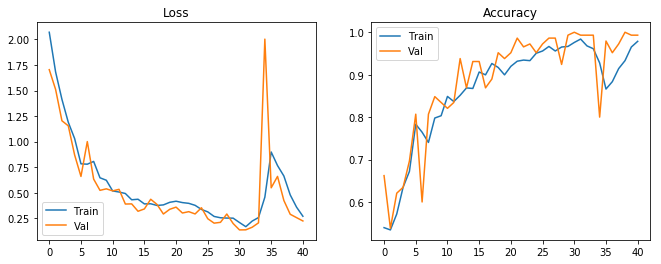

Final epoch results:
Balanced Accuracy: 99.25 %
Sensitivity: 100.00 %
Specificity: 98.51 %
Train on 747 samples, validate on 145 samples
Epoch 1/45
747/747 [==============================] - 37s 49ms/step - loss: 2.0779 - acc: 0.5274 - val_loss: 1.7940 - val_acc: 0.5448
Epoch 2/45
747/747 [==============================] - 35s 46ms/step - loss: 1.6348 - acc: 0.5382 - val_loss: 1.4008 - val_acc: 0.5655
Epoch 3/45
747/747 [==============================] - 35s 47ms/step - loss: 1.2901 - acc: 0.6131 - val_loss: 1.1577 - val_acc: 0.6828
Epoch 4/45
747/747 [==============================] - 35s 46ms/step - loss: 1.0417 - acc: 0.7376 - val_loss: 0.8606 - val_acc: 0.8000
Epoch 5/45
747/747 [==============================] - 34s 46ms/step - loss: 0.8972 - acc: 0.7470 - val_loss: 0.7984 - val_acc: 0.7517
Epoch 6/45
747/747 [==============================] - 35s 47ms/step - loss: 0.7912 - acc: 0.7831 - val_loss: 0.6916 - val_acc: 0.7931
Epoch 7/45
747/747 [==============================] - 35s 4

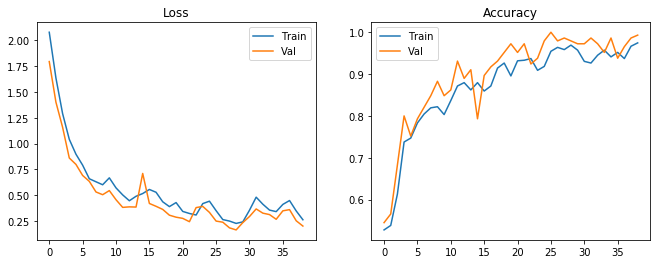

Final epoch results:
Balanced Accuracy: 99.25 %
Sensitivity: 100.00 %
Specificity: 98.51 %


In [20]:
# training args
lr = 0.001
lr_decay = 0.

num_trials = 10
patience = 10
store_models = True

best_epoch_acc = []
final_epoch_sens = []
final_epoch_spec = []

for i in range(num_trials):
    # init model
    model = SixtyFourNet(drop_rate=0.3, weight_dcay=0.01, input_shape=X_train.shape)
    opti = Adam(lr=lr, decay=lr_decay)
    model.compile(loss='binary_crossentropy', optimizer=opti, metrics=['accuracy'])
    
    #callbacks
    earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0, mode='auto')
    model_checkpoint = ModelCheckpoint(os.path.join(result_dir, "model_trial_%i.h5" %i), monitor='val_acc', verbose=0, save_best_only=True, mode='max')

    if store_models:
        callbacks = [earlystopping, model_checkpoint]
    else:
        callbacks = [earlystopping]
    
    # Start training
    history = model.fit(
        X_train,
        y_train,
        epochs=num_epochs,
        batch_size=b,
        validation_data=(X_val,y_val),
        callbacks=callbacks,
        shuffle=True
    )
    training_time = time.time() - start_time
    # Plot training curves
    plt.figure(figsize=(11, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.legend(["Train", "Val"])
    plt.title("Loss")
    plt.subplot(1, 2, 2)
    plt.plot(history.history["acc"])
    plt.plot(history.history["val_acc"])
    plt.legend(["Train", "Val"])
    plt.title("Accuracy")
    plt.show()    
    # Evaluation
    y_pred = model.predict(X_val, batch_size=1).flatten() # predict and turn into 1-dimensional array
    sens = sensitivity(y_val, y_pred>0.5)
    spec = specificity(y_val, y_pred>0.5)
    # Store results
    best_epoch = np.argmax(history.history["val_acc"])
    best_epoch_acc.append(history.history["val_acc"][best_epoch])
    final_epoch_sens.append(sens)
    final_epoch_spec.append(spec)
    # Print results
    print("Final epoch results:")
    print("Balanced Accuracy: {:.2f} %".format(((sens + spec) * 100) / 2))
    print("Sensitivity: {:.2f} %".format(sens * 100))
    print("Specificity: {:.2f} %".format(spec * 100))

In [21]:
print("All best val accuracies: {}".format(best_epoch_acc))
print("Average best validation accuracy over {} trials: {:.5f} (std: {:.5f})".format(num_trials, np.mean(best_epoch_acc), np.std(best_epoch_acc)))

All best val accuracies: [1.0, 0.993103448275862, 1.0, 1.0, 1.0, 1.0, 0.993103448275862, 1.0, 1.0, 1.0]
Average best validation accuracy over 10 trials: 0.99862 (std: 0.00276)


In [22]:
print("Final epochs sensitivity: {}".format(final_epoch_sens))
print("Final epochs specificity: {}".format(final_epoch_spec))

Final epochs sensitivity: [1.0, 1.0, 1.0, 0.9743589743589743, 0.9743589743589743, 0.9743589743589743, 0.9871794871794872, 0.9871794871794872, 1.0, 1.0]
Final epochs specificity: [0.9402985074626866, 0.9701492537313433, 0.9850746268656716, 1.0, 1.0, 1.0, 0.9850746268656716, 1.0, 0.9850746268656716, 0.9850746268656716]


In [23]:
print("Training Time: {}h:{}m:{}s".format(
            training_time//3600, (training_time//60)%60, training_time%60))

Training Time: 3.0h:46.0m:20.295594930648804s


In [1]:
np.max(history.history["val_acc"])

NameError: name 'np' is not defined

In [25]:
quit()